In [1]:
import pandas as pd
import datetime as dt
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
elo_df = pd.read_csv(r'data\elo_data_set.csv', parse_dates=[0])
teams = []
for i in elo_df['team'].unique(): #constructs list of team names
    teams.append(i)
elo_df.head()

,datetime,team,season,opp,day_week,week,W/L,ot,record,home/away,...,defense_expected_points,sp_expected_points,team_elo_before_all,team_elo_after_all,opp_elo_before_all,opp_elo_after_all,team_elo_before_season,team_elo_after_season,opp_elo_before_season,opp_elo_after_season
0,2002-09-05 20:38:00,NYG,2002,SFO,Thu,1,0.0,0.0,0-1,HOME,...,-0.79,3.46,1500.0,1485.0,1500.0,1515.0,1500.0,1480.0,1500.0,1520.0
1,2002-09-08 13:04:00,CAR,2002,BAL,Sun,1,1.0,0.0,1-0,HOME,...,6.68,4.20,1500.0,1515.0,1500.0,1485.0,1500.0,1520.0,1500.0,1480.0
2,2002-09-08 13:04:00,CHI,2002,MIN,Sun,1,1.0,0.0,1-0,HOME,...,-1.20,1.01,1500.0,1515.0,1500.0,1485.0,1500.0,1520.0,1500.0,1480.0
3,2002-09-08 13:04:00,CLE,2002,KAN,Sun,1,0.0,0.0,0-1,HOME,...,-17.94,1.15,1500.0,1485.0,1500.0,1515.0,1500.0,1480.0,1500.0,1520.0
4,2002-09-08 13:04:00,BUF,2002,NYJ,Sun,1,0.0,1.0,0-1,HOME,...,0.59,-7.81,1500.0,1485.0,1500.0,1515.0,1500.0,1480.0,1500.0,1520.0


In [3]:
# separates out played games, and the upcoming week.
#season_df = elo_df[elo_df['season']==dt.datetime.today()]
season_df = elo_df[elo_df['season']==dt.datetime.today().year]

history_df = elo_df[elo_df['datetime'] < dt.datetime.today()]

future_df = season_df[season_df['datetime'] >= dt.datetime.today()]


upcoming_week = history_df['week'].iloc[-1] + 1
future_df = future_df[future_df['week'] == upcoming_week]
future_df = future_df[['datetime', 'team', 'opp', 'team_score', 'opp_score', 'team_elo_before_all', 'opp_elo_before_all', 'team_elo_before_season', 'opp_elo_before_season', 'W/L']]
print(f'Week to predict : {upcoming_week}')

Week to predict : 9


In [4]:
# Generates a dictionary of dataframes for points gained/allowed per team. This allows convenient generation of the distributions fed into the game 
team_data_dict_all = {}
team_data_dict_season = {}
for i in range(len(teams)):
    team = teams[i]
    team_data_all = pd.DataFrame()
    team_data_season = pd.DataFrame()
    
    team_off_all = []
    team_def_all = []
    team_elo_all = []
    
    team_off_season = []
    team_def_season = []
    team_elo_season = []
    
    team_df_all = history_df[(history_df['team'] == f'{team}') | (history_df['opp'] == f'{team}')]
    team_df_season = season_df[(season_df['team'] == f'{team}') | (season_df['opp'] == f'{team}')]
    team_df_all.reset_index(inplace=True)
    team_df_all.drop('index', axis=1, inplace=True)
    
    team_df_season.reset_index(inplace=True)
    team_df_season.drop('index', axis=1, inplace=True)
    
    for x in range(len(team_df_all)):
        if team_df_all['team'][x] == f'{team}':
            team_off_all.append(team_df_all['team_score'][x])
            team_def_all.append(team_df_all['opp_score'][x])
            team_elo_all.append(team_df_all['team_elo_before_all'][x])
        else:
            team_off_all.append(team_df_all['opp_score'][x])
            team_def_all.append(team_df_all['team_score'][x])
            team_elo_all.append(team_df_all['opp_elo_before_all'][x])
            
    for y in range(len(team_df_season)):
        if team_df_all['team'][y] == f'{team}':
            team_off_season.append(team_df_season['team_score'][y])
            team_def_season.append(team_df_season['opp_score'][y])
            team_elo_season.append(team_df_season['team_elo_before_all'][y])
        else:
            team_off_season.append(team_df_season['opp_score'][y])
            team_def_season.append(team_df_season['team_score'][y])
            team_elo_season.append(team_df_season['opp_elo_before_all'][y])
    
    team_data_all['team_off'] = team_off_all
    team_data_all['team_def'] = team_def_all
    team_data_all['elo'] = team_elo_all
    team_data_dict_all[team] = team_data_all
    
    team_data_season['team_off'] = team_off_season
    team_data_season['team_def'] = team_def_season
    team_data_season['elo'] = team_elo_season
    team_data_season.dropna(inplace=True)
    team_data_dict_season[team] = team_data_season
      
   
print(len(team_data_dict_all.keys()), ' ' , len(team_data_dict_season.keys()))

C:\Users\fitzp\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


32   32


In [5]:
# Games to be predicted
future_df.reset_index(inplace=True)
future_df.drop('index', axis=1, inplace=True)
future_df['team_elo_prediction_all%'] = np.nan
future_df['opp_elo_prediction_all%'] = np.nan
future_df['team_gauss_prediction_all%'] = np.nan
future_df['opp_gauss_prediction_all%'] = np.nan
future_df['tie_gauss_prediction_all%'] = np.nan

future_df['team_elo_prediction_season%'] = np.nan
future_df['opp_elo_prediction_season%'] = np.nan
future_df['team_gauss_prediction_season%'] = np.nan
future_df['opp_gauss_prediction_season%'] = np.nan
future_df['tie_gauss_prediction_season%'] = np.nan

future_df

,datetime,team,opp,team_score,opp_score,team_elo_before_all,opp_elo_before_all,team_elo_before_season,opp_elo_before_season,W/L,team_elo_prediction_all%,opp_elo_prediction_all%,team_gauss_prediction_all%,opp_gauss_prediction_all%,tie_gauss_prediction_all%,team_elo_prediction_season%,opp_elo_prediction_season%,team_gauss_prediction_season%,opp_gauss_prediction_season%,tie_gauss_prediction_season%
0,2020-11-05 20:20:00,SFO,GNB,NaN,NaN,1555.516930,1612.575065,1461.876275,1425.409243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-11-08 13:00:00,TEN,CHI,NaN,NaN,1573.785284,1531.992276,1441.804211,1448.051275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-11-08 13:00:00,ATL,DEN,NaN,NaN,1472.503890,1471.703406,1441.536172,1521.006053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-11-08 13:00:00,WAS,NYG,NaN,NaN,1350.999465,1324.271286,1502.915066,1503.233949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-11-08 13:00:00,BUF,SEA,NaN,NaN,1551.293114,1648.828924,1504.580219,1467.541993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-11-08 13:00:00,IND,BAL,NaN,NaN,1498.704297,1651.907134,1469.650832,1376.672009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-11-08 13:00:00,MIN,DET,NaN,NaN,1541.298984,1396.059333,1486.136589,1386.462557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-11-08 13:00:00,KAN,CAR,NaN,NaN,1730.119034,1417.051959,1522.907386,1391.521439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-11-08 13:00:00,JAX,HOU,NaN,NaN,1332.700280,1492.607616,1403.673645,1452.439744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-11-08 16:05:00,LAC,LVR,NaN,NaN,1425.303947,1459.716219,1451.559846,1462.925719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def color_predict(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0.5 else 'green'
    return 'color: %s' % color

In [7]:
# functions to simulate games

def elo_expected(teamA, teamB, dictionary):
    rating_A = dictionary[teamA]['elo'].iloc[-1]
    rating_B = dictionary[teamB]['elo'].iloc[-1]
    expected_A = 1 / (1 + 10 ** ((rating_B - rating_A) / 400 ))
    expected_B = 1 / (1 + 10 ** ((rating_A - rating_B) / 400 ))
    return [expected_A, expected_B]

def elo_game_sim(teamA, teamB, dictionary):
    win_values = elo_expected(teamA, teamB, dictionary)
    win_gen = rnd.random()
    if win_values[0] > win_values[1]:
        if win_gen < win_values[0]:
            return [1, 0]
        else:
            return [0, 1]
    if win_values[0] < win_values[1]:
        if win_gen < win_values[1]:
            return [0, 1]
        else:
            return[1, 0]

def elo_series_sim(teamA, teamB, runs, dictionary):
    games = []
    teamA_wins = 0
    teamB_wins = 0
    for i in range(runs):
        game = elo_game_sim(teamA, teamB, dictionary)
        games.append(game)
        if game[0] == 1:
            teamA_wins += 1
        else:
            teamB_wins += 1
    return [teamA_wins, teamB_wins]

def gauss_game_sim(teamA, teamB, dictionary):
    team_A_score = (rnd.gauss(dictionary[teamA]['team_off'].mean(), dictionary[teamA]['team_off'].std()) + rnd.gauss(dictionary[teamB]['team_def'].mean(), dictionary[teamB]['team_def'].std()))/2
    team_B_score = (rnd.gauss(dictionary[teamB]['team_off'].mean(), dictionary[teamB]['team_off'].std()) + rnd.gauss(dictionary[teamA]['team_def'].mean(), dictionary[teamA]['team_def'].std()))/2
    if int(round(team_A_score)) > int(round(team_B_score)):
        return 1
    elif int(round(team_A_score)) < int(round(team_B_score)):
        return -1
    else: 
        gauss_game_sim(teamA, teamB, dictionary)

def gauss_series_sim(teamA, teamB, runs, dictionary):
    games = []
    teamA_wins = 0
    teamB_wins = 0
    ties = 0
    for i in range(runs):
        game = gauss_game_sim(teamA, teamB, dictionary)
        games.append(game)
        if game == 1:
            teamA_wins += 1
        elif game== -1:
            teamB_wins += 1
        else:
            ties += 1
    return [teamA_wins, teamB_wins, ties]

In [8]:
# simulations and future_df update
num_sims = 50000
for i in range(len(future_df)):
    teamA = future_df['team'].iloc[i]
    teamB = future_df['opp'].iloc[i]
    
    elo_result = elo_series_sim(teamA, teamB, num_sims, team_data_dict_all)
    elo_result_A = elo_result[0] / (elo_result[0] + elo_result[1])
    elo_result_B = elo_result[1] / (elo_result[0] + elo_result[1])
    future_df['team_elo_prediction_all%'].iloc[i] = elo_result_A
    future_df['opp_elo_prediction_all%'].iloc[i] = elo_result_B
    
    gauss_result = gauss_series_sim(teamA, teamB, num_sims, team_data_dict_all)
    gauss_result_A = gauss_result[0] / (gauss_result[0] + gauss_result[1] + gauss_result[2])
    gauss_result_B = gauss_result[1] / (gauss_result[0] + gauss_result[1] + gauss_result[2])
    gauss_result_tie = gauss_result[2] / (gauss_result[0] + gauss_result[1] + gauss_result[2])
    future_df['team_gauss_prediction_all%'].iloc[i] = gauss_result_A
    future_df['opp_gauss_prediction_all%'].iloc[i] = gauss_result_B
    future_df['tie_gauss_prediction_all%'].iloc[i] = gauss_result_tie
    
    elo_result_season = elo_series_sim(teamA, teamB, num_sims, team_data_dict_season)
    elo_result_A_season = elo_result_season[0] / (elo_result_season[0] + elo_result_season[1])
    elo_result_B_season = elo_result_season[1] / (elo_result_season[0] + elo_result_season[1])
    future_df['team_elo_prediction_season%'].iloc[i] = elo_result_A_season
    future_df['opp_elo_prediction_season%'].iloc[i] = elo_result_B_season
    
    gauss_result_season = gauss_series_sim(teamA, teamB, num_sims, team_data_dict_season)
    gauss_result_A_season = gauss_result_season[0] / (gauss_result_season[0] + gauss_result_season[1] + gauss_result_season[2])
    gauss_result_B_season = gauss_result_season[1] / (gauss_result_season[0] + gauss_result_season[1] + gauss_result_season[2])
    gauss_result_tie_season = gauss_result_season[2] / (gauss_result_season[0] + gauss_result_season[1] + gauss_result_season[2])
    future_df['team_gauss_prediction_season%'].iloc[i] = gauss_result_A_season
    future_df['opp_gauss_prediction_season%'].iloc[i] = gauss_result_B_season
    future_df['tie_gauss_prediction_season%'].iloc[i] = gauss_result_tie_season
    
    print('--------------------------------------------------------------')
    print(f'TEAMS : {teamA} | {teamB}')
    print(f'HISTORICAL PREDICTION: elo_result: {elo_result} | gaussian_result: {gauss_result}')
    print(f'SEASON PREDICTION: elo_result: {elo_result_season} | gaussian_result: {gauss_result_season}')

C:\Users\fitzp\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


--------------------------------------------------------------
TEAMS : SFO | GNB
HISTORICAL PREDICTION: elo_result: [20419, 29581] | gaussian_result: [19121, 28994, 1885]
SEASON PREDICTION: elo_result: [20444, 29556] | gaussian_result: [19990, 28065, 1945]
--------------------------------------------------------------
TEAMS : TEN | CHI
HISTORICAL PREDICTION: elo_result: [29012, 20988] | gaussian_result: [23060, 24953, 1987]
SEASON PREDICTION: elo_result: [29169, 20831] | gaussian_result: [18529, 28957, 2514]
--------------------------------------------------------------
TEAMS : ATL | DEN
HISTORICAL PREDICTION: elo_result: [25342, 24658] | gaussian_result: [23580, 24419, 2001]
SEASON PREDICTION: elo_result: [24455, 25545] | gaussian_result: [32187, 15771, 2042]
--------------------------------------------------------------
TEAMS : WAS | NYG
HISTORICAL PREDICTION: elo_result: [24838, 25162] | gaussian_result: [21146, 26802, 2052]
SEASON PREDICTION: elo_result: [24762, 25238] | gaussian_r

In [9]:
future_df

,datetime,team,opp,team_score,opp_score,team_elo_before_all,opp_elo_before_all,team_elo_before_season,opp_elo_before_season,W/L,team_elo_prediction_all%,opp_elo_prediction_all%,team_gauss_prediction_all%,opp_gauss_prediction_all%,tie_gauss_prediction_all%,team_elo_prediction_season%,opp_elo_prediction_season%,team_gauss_prediction_season%,opp_gauss_prediction_season%,tie_gauss_prediction_season%
0,2020-11-05 20:20:00,SFO,GNB,NaN,NaN,1555.516930,1612.575065,1461.876275,1425.409243,NaN,0.40838,0.59162,0.38242,0.57988,0.03770,0.40888,0.59112,0.39980,0.56130,0.03890
1,2020-11-08 13:00:00,TEN,CHI,NaN,NaN,1573.785284,1531.992276,1441.804211,1448.051275,NaN,0.58024,0.41976,0.46120,0.49906,0.03974,0.58338,0.41662,0.37058,0.57914,0.05028
2,2020-11-08 13:00:00,ATL,DEN,NaN,NaN,1472.503890,1471.703406,1441.536172,1521.006053,NaN,0.50684,0.49316,0.47160,0.48838,0.04002,0.48910,0.51090,0.64374,0.31542,0.04084
3,2020-11-08 13:00:00,WAS,NYG,NaN,NaN,1350.999465,1324.271286,1502.915066,1503.233949,NaN,0.49676,0.50324,0.42292,0.53604,0.04104,0.49524,0.50476,0.71922,0.24296,0.03782
4,2020-11-08 13:00:00,BUF,SEA,NaN,NaN,1551.293114,1648.828924,1504.580219,1467.541993,NaN,0.35292,0.64708,0.38974,0.57302,0.03724,0.44324,0.55676,0.68070,0.26940,0.04990
5,2020-11-08 13:00:00,IND,BAL,NaN,NaN,1498.704297,1651.907134,1469.650832,1376.672009,NaN,0.25736,0.74264,0.45800,0.50468,0.03732,0.25846,0.74154,0.70140,0.26248,0.03612
6,2020-11-08 13:00:00,MIN,DET,NaN,NaN,1541.298984,1396.059333,1486.136589,1386.462557,NaN,0.65776,0.34224,0.57452,0.38664,0.03884,0.69562,0.30438,0.59610,0.35594,0.04796
7,2020-11-08 13:00:00,KAN,CAR,NaN,NaN,1730.119034,1417.051959,1522.907386,1391.521439,NaN,0.84340,0.15660,0.51420,0.44990,0.03590,0.84594,0.15406,0.57796,0.37626,0.04578
8,2020-11-08 13:00:00,JAX,HOU,NaN,NaN,1332.700280,1492.607616,1403.673645,1452.439744,NaN,0.28696,0.71304,0.45784,0.50144,0.04072,0.24342,0.75658,0.25096,0.70516,0.04388
9,2020-11-08 16:05:00,LAC,LVR,NaN,NaN,1425.303947,1459.716219,1451.559846,1462.925719,NaN,0.49148,0.50852,0.64998,0.31284,0.03718,0.48778,0.51222,0.52764,0.43066,0.04170


In [10]:
future_df.to_csv(f'data/predictions/{dt.datetime.today().date()}_week_{upcoming_week}_predictions.csv', index=False)

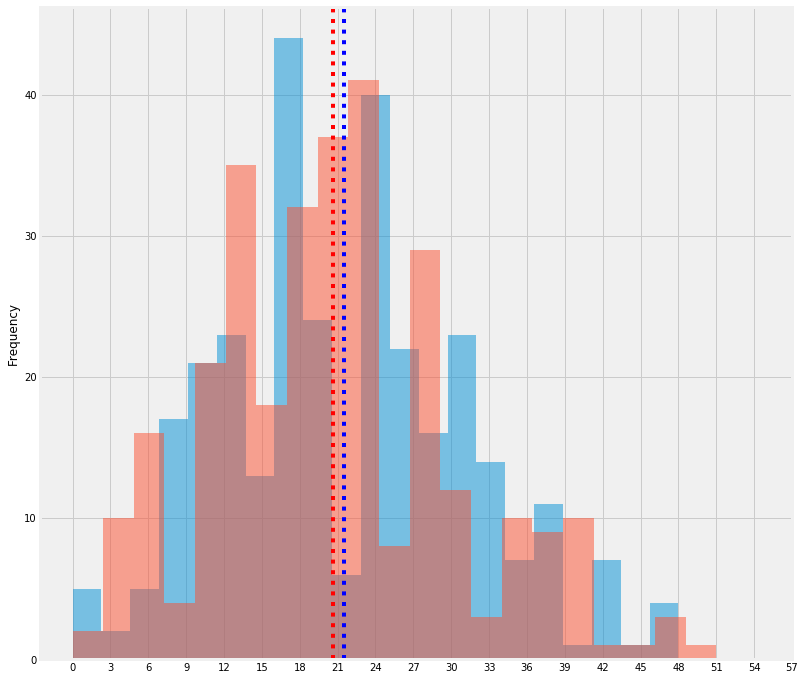

In [11]:
team_data_dict_all['TEN']['team_off'].plot(kind='hist', figsize = (12,12), bins=21, alpha=0.5)
team_data_dict_all['CHI']['team_off'].plot(kind='hist', figsize = (12,12), bins=21, alpha=0.5)
plt.axvline(team_data_dict_all['TEN']['team_off'].mean(), linestyle=":", color='b')
plt.axvline(team_data_dict_all['CHI']['team_off'].mean(), linestyle=':', color = 'r')
plt.xticks(range(0, 60, 3))
plt.show()

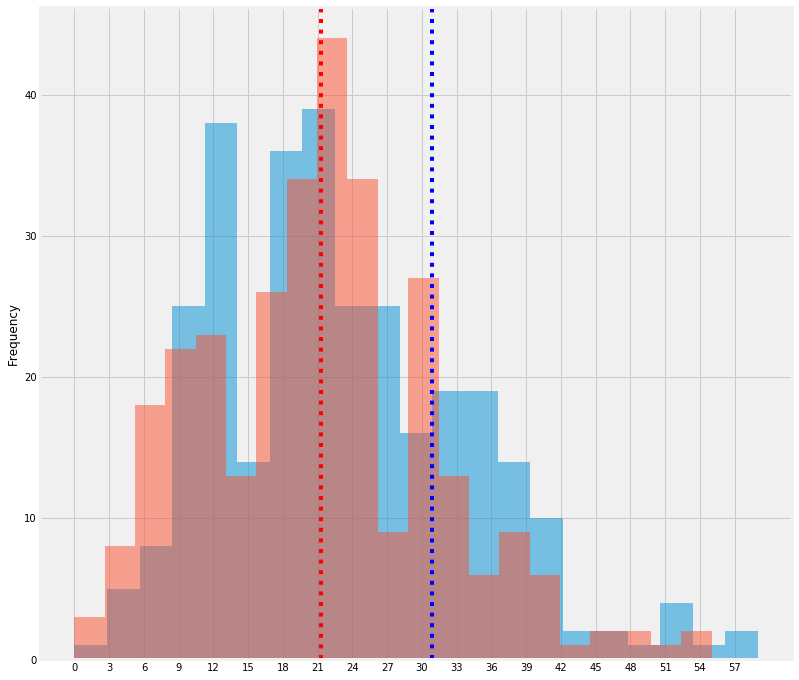

In [12]:
team_data_dict_all['TEN']['team_def'].plot(kind='hist', figsize = (12,12), bins=21, alpha=0.5)
team_data_dict_all['CHI']['team_def'].plot(kind='hist', figsize = (12,12), bins=21, alpha=0.5)
plt.axvline(team_data_dict_season['TEN']['team_def'].mean(), linestyle=":", color='b')
plt.axvline(team_data_dict_season['CHI']['team_def'].mean(), linestyle=':', color = 'r')
plt.xticks(range(0, 60, 3))
plt.show()

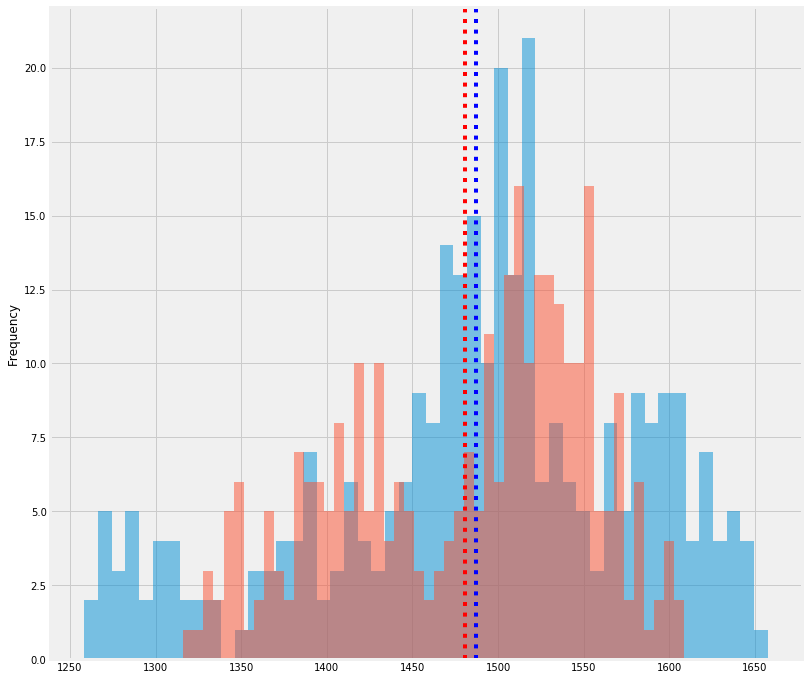

In [13]:
team_data_dict_all['TEN']['elo'].plot(kind='hist', figsize = (12,12), alpha=0.5, orientation = 'vertical', bins = 50)
team_data_dict_all['CHI']['elo'].plot(kind='hist', figsize = (12,12), alpha=0.5, orientation = 'vertical', bins = 50)
plt.axvline(team_data_dict_all['TEN']['elo'].mean(), linestyle=":", color='b')
plt.axvline(team_data_dict_all['CHI']['elo'].mean(), linestyle=':', color = 'r')

